In [ ]:
from g4f.client import Client
import random
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

# Генерация текстов
Сгенерирую тексты для различного набора комбинаций значений бинарных колонок с помощью ChatGPT. Далее на сгенерированном корпусе обучу языковую модель предсказывать вектор фичей по промпту.

In [ ]:
flags = [
    "рвота",
    "одышка",
    "потливость",
    "головная боль",
    "боль в груди",
    "головокружение",
    "потеря равновесия",
    "отсутствие концентрации"
]

# Функция для генерации случайного набора флагов
def generate_random_flags():
    return {flag: random.choice([True, False]) for flag in flags}

# Функция для создания жалобы на основе флагов
def generate_complaint(flags):
    prompt = (
        "Сгенерируй разнообразный текст жалобы пациента от первого лица без переноса строк, у которого есть следующие симптомы:\n"
        + ", ".join([flag for flag, present in flags.items() if present]) +
        " используй разные паттерны. Без лишних слов, только жалобы. Желательно использовать другие слова симптомов, чтобы был понятен контекст."
    )
    client = Client()
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
    )
    return response.choices[0].message.content

In [ ]:
# Генерация 1000 жалоб
data = []

for _ in range(1000):
    flags = generate_random_flags()
    complaint = generate_complaint(flags)
    data.append({"complaint": complaint, "flags": flags})

In [ ]:
# Сохранение данных в JSON-файл
with open("complaints_data.json", "w", encoding="utf-8") as f:
    json.dump(data, f, ensure_ascii=False, indent=4)

# Обучение модели
Обучу небольшую GRU модель предсказывать вектор фичей по промпту. Проверю качество на hold-out валидации.

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Достаем из сгенерированного корпуса тексты и векторы в отдельные переменные
# и приводим их к удобному виду

texts = [x['complaint'] for x in data]
vecs = np.array([list(x['flags'].values()) for x in data]).astype('int')

In [ ]:
# Выполняем сплит данных. На трейне обучимся, на тесте проверим качество

X_train_texts, X_test_texts, y_train_vectors, y_test_vectors = train_test_split(texts,
                                                                                vecs,
                                                                                test_size=0.2,
                                                                                random_state=42)

In [ ]:
# Векторизую текста для подачи на вход в нейронную сеть

vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train_texts).toarray()
X_test_tfidf = vectorizer.transform(X_test_texts).toarray()

In [ ]:
# Кладем на cuda переменные для возможности обучаться на гпу

X_train_tensor = torch.FloatTensor(X_train_tfidf).to(device)
y_train_tensor = torch.FloatTensor(y_train_vectors).to(device)
X_test_tensor = torch.FloatTensor(X_test_tfidf).to(device)
y_test_tensor = torch.FloatTensor(y_test_vectors).to(device)

In [ ]:
class GRUNetwork(nn.Module):
    """
    Инициализация нейронной сети
    Кол-во входов 2047 - кол-во фичей у вектора tf-idf
    Кол-во выходов 8 - кол-во фичей у выходного вектора
    """
    def __init__(self):
        super(GRUNetwork, self).__init__()
        self.gru = nn.GRU(input_size=2047, hidden_size=32,
                          batch_first=True)
        self.fc = nn.Linear(32, 8)

    def forward(self, x):
        # Прямое прохождение нейронной сети
        x = x.unsqueeze(1)
        out, _ = self.gru(x)
        out = out[:, -1]
        out = self.fc(out)

        # Возвращаем сигмоиду для получения вероятностей
        # по каждой фиче
        return torch.sigmoid(out)

In [ ]:
# Создаем объекты класса модели, функции потерь и оптимизатора

model = GRUNetwork().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Инициализируем цикл обучения на 1000 итераций

num_epochs = 1000
losses = []

for epoch in range(num_epochs):
    model.train()
    
    optimizer.zero_grad()
    
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    # Выводим логи каждые 100 итераций
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/1000], Loss: 0.5420
Epoch [200/1000], Loss: 0.2821
Epoch [300/1000], Loss: 0.1481
Epoch [400/1000], Loss: 0.0862
Epoch [500/1000], Loss: 0.0549
Epoch [600/1000], Loss: 0.0376
Epoch [700/1000], Loss: 0.0271
Epoch [800/1000], Loss: 0.0204
Epoch [900/1000], Loss: 0.0159
Epoch [1000/1000], Loss: 0.0127


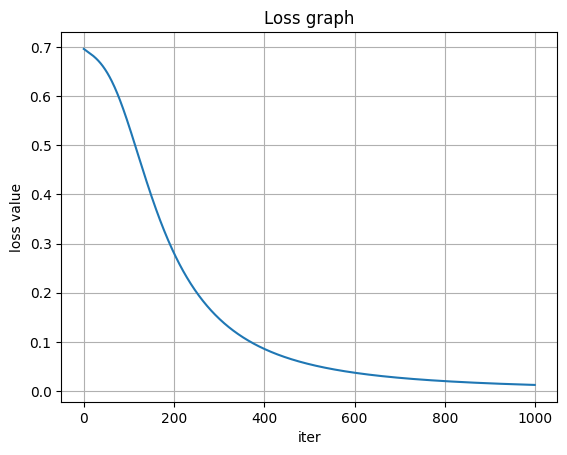

In [ ]:
plt.plot(losses)
plt.grid()
plt.xlabel('iter')
plt.ylabel('loss value')
plt.title('Loss graph')

plt.show()

In [ ]:
# Тестим модель на тестовых данных. Отсекаем значения фичей по вероятности 0.5

model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    predicted_vectors = (test_outputs > 0.5).float()

In [34]:
pred_real_eq = predicted_vectors.to('cpu').numpy() == y_test_tensor.to('cpu').numpy()

print(f"Доля полностью угаданных векторов {np.all(pred_real_eq, axis=1).sum() / pred_real_eq.shape[0]:.2f}")
print(f"Общая доля верно угаданных значений фичей по всем векторам {pred_real_eq.sum() / pred_real_eq.shape[0] / pred_real_eq.shape[1]:.2f}")

Доля полностью угаданных векторов 0.49
Общая доля верно угаданных значений фичей по всем векторам 0.90


Видно, что модель в половине случаев идеально предсказала векторы, что довольно мало. Однако доля всех верно угаданных значений фичей по всем векторам довольно высокая.

In [ ]:
# Сохраню модель

torch.save(model.state_dict(), 'gru_prompt_to_8_vec_weights.pth')